In [7]:
import json
import requests
import pandas as pd

In [8]:
from elasticsearch8 import Elasticsearch
from datetime import datetime
import json
def config(k):
    with open(f'/configs/default/shared-data/{k}', 'r') as f:
        return f.read()

def main():
    try:
        es = Elasticsearch (
                'https://127.0.0.1:9200',
                request_timeout=60,
                verify_certs= False,
                ssl_show_warn= False,
                basic_auth=('elastic','elastic')
            )


        query = {
        "size":100,
            "_source": ["phn_name","phn_code","dth_resp88"],
            "query": {
                "match_all": {}
            }
        }


        result = es.search(index="premature_mortality_2011", body=query)
        docs = result['hits']['hits']
        features = {}
        for doc in docs:
            _id = doc['_id']
            death_ratio = doc['_source']['dth_resp88']/100000
            phn_name = doc['_source']['phn_name']
            phn_code = doc['_source']['phn_code']
            features[_id] = {
                '_id': _id,
                'death_ratio':death_ratio,
                'phn_code': phn_code,
                'phn_name': phn_name
            }

        ids = list(features.keys())
        
        aggregation_data = []
        for id in ids:
            print("searching: ", id)
            query = {
                "size": 10000,
                    "query": {
                        "bool": {
                            "must": [
                                {
                                    "exists": {
                                        "field": "geometry"
                                    }
                                }
                            ],
                            "filter": {
                                "geo_shape": {
                                    "geometry": {
                                        "indexed_shape": {
                                            "index": "premature_mortality_2011",
                                            "id": id,
                                            "path": "geometry"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }

            result2 = es.search(index="air-qualities", body=query)
            aggs_data = result2['hits']['hits']
            for data in aggs_data:
                if data['_source']['averageValue']!=None:
                    aggregation_data.append({
                        '_id': id,
                        'dataName': data['_source']['dataName'],
                        'avgValue': data['_source']['averageValue'],
                        'since': data['_source']['since']
                    })


        unique_data_names = set()
        unique_since = set()
        for data in aggregation_data:
            unique_data_names.add(data['dataName'])
            unique_since.add(data['since'])
        
        sorted_date_times = sorted(unique_since, key=lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
        for id in ids:
            for data_name in unique_data_names:
                values = []
                for since in sorted_date_times:
                    values_since = []
                    for data in aggregation_data:
                        if data['_id'] == id and data['dataName'] == data_name and data['since']==since:
                            values_since.append(data['avgValue'])
                    if len(values_since)!=0:
                        values.append(sum(values_since)/len(values_since))
                    else:
                        values.append(None)
                features[id][data_name] = values
                
        response = {
            'status_code': 200,
            'data': list(features.values())
        }
        return json.dumps(response)
    except Exception as e:
        error_response = {'status_code': 500, 'error_message': str(e)}
        return json.dumps(error_response)

In [9]:
# response = requests.get("http://127.0.0.1:9090/EPA/air-quality-phn")
response = main()

searching:  hMzehI8BrPb-hKkEoiq8


In [10]:
print(response)

{"status_code": 500, "error_message": "BadRequestError(400, 'illegal_argument_exception', 'Shape with ID [hMzehI8BrPb-hKkEoiq8] not found')"}


In [3]:
data = response.json().get('data')

Average values of polutions in Public Health Network (PHN) areas in Victoria 

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.json_normalize(data)  # 使用 json_normalize() 函数加载数据到 DataFrame


features = ['Particles', 'PM2.5', 'PM10', 'Visibility', 'API', 'O3', 'NO2', 'SO2', 'CO']


# 对于每个特征，将列表展开成新的列
for feature in features:
    # 对于每个特征，将列表展开成新的列，并命名为原特征名加上索引
    # df = pd.concat([df, df[feature].apply(pd.Series).add_prefix(feature+'_')], axis=1)
    df[feature+'_mean'] = df[feature].apply(lambda x: sum(filter(None, x))/len(x) if isinstance(x, list) and any(x) else None)

# 删除原始的特征列
df.drop(columns=features, inplace=True)
df.dropna(how='all', subset=df.columns[4:], inplace=True)
df.drop(columns=['_id'])

df

NotImplementedError: 

Correlation matrix to analyse the relativity of different pollutant with the respiratory system mortality

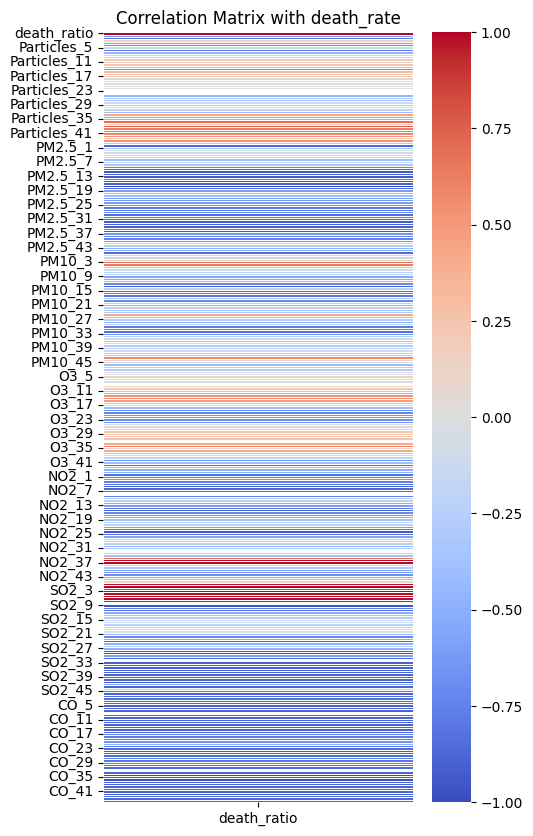

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.json_normalize(data)  # 使用 json_normalize() 函数加载数据到 DataFrame


features = ['Particles', 'PM2.5', 'PM10', 'Visibility', 'API', 'O3', 'NO2', 'SO2', 'CO']
# 假设 df 是你的 DataFrame，features 是要展开的特征列表
pollutant_features = ['Particles', 'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']

# 对于每个特征，将列表展开成新的列
for feature in pollutant_features:
    # 对于每个特征，将列表展开成新的列，并命名为原特征名加上索引
    df = pd.concat([df, df[feature].apply(pd.Series).add_prefix(feature+'_')], axis=1)
    # df[feature+'_mean'] = df[feature].apply(lambda x: sum(filter(None, x))/len(x) if isinstance(x, list) and any(x) else None)

# 删除原始的特征列
df.drop(columns=features, inplace=True)

df = df.dropna(subset=df.columns[4:], how='all')

df = df.drop(columns=['_id','phn_code', 'phn_name'])
correlation_matrix = df.corr()
# 绘制热图
plt.figure(figsize=(5, 10))
sns.heatmap(correlation_matrix[['death_ratio']], annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix with death_rate")
plt.show()

